In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from datetime import datetime, timedelta, date
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from time import time
import joblib

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

Dataset obtained from [here](https://www.kaggle.com/purpleyupi/strava-data)

In [87]:
df = pd.read_csv("../data/datasets_504615_944541_strava_full_data.csv")
df.head()

,Unnamed: 0,average_speed,max_speed,average_heartrate,max_heartrate,distance,elapsed_time,moving_time,total_elevation_gain,elev_high,type,start_date_local,kudos_count
0,0,3.142,5.3,NaN,NaN,11443.2,1:03:50,1:00:42,73.0,115.0,Run,2020-01-18T12:00:36,12
1,1,3.410,7.4,NaN,NaN,9486.0,0:48:51,0:46:22,36.1,96.9,Run,2020-01-17T19:00:58,13
2,2,3.273,4.0,NaN,NaN,8854.8,0:45:32,0:45:05,16.0,117.2,Run,2020-01-13T18:37:29,3
3,3,3.259,4.0,NaN,NaN,7717.5,0:39:35,0:39:28,10.0,131.6,Run,2020-01-10T18:36:52,2
4,4,3.222,4.0,NaN,NaN,7659.5,0:41:33,0:39:37,12.0,107.4,Run,2020-01-08T18:37:24,17


In [88]:
df.shape

(1121, 13)

In [89]:
df = df.drop(columns=["Unnamed: 0", "average_heartrate", "max_heartrate", "kudos_count", "total_elevation_gain", "elev_high", "type", "elapsed_time"])
df.head()

,average_speed,max_speed,distance,moving_time,start_date_local
0,3.142,5.3,11443.2,1:00:42,2020-01-18T12:00:36
1,3.410,7.4,9486.0,0:46:22,2020-01-17T19:00:58
2,3.273,4.0,8854.8,0:45:05,2020-01-13T18:37:29
3,3.259,4.0,7717.5,0:39:28,2020-01-10T18:36:52
4,3.222,4.0,7659.5,0:39:37,2020-01-08T18:37:24


In [90]:
df["start_date_local"] = pd.to_datetime(df["start_date_local"], format='%Y-%m-%dT%H:%M:%S')
df["start_date"] = df["start_date_local"].apply(lambda x: x.date())
df["year"] = df["start_date_local"].apply(lambda x: x.year)
df["month"] = df["start_date_local"].apply(lambda x: x.month)
df["day"] = df["start_date_local"].apply(lambda x: x.day)
df["hour"] = df["start_date_local"].apply(lambda x: x.hour)
df["minute"] = df["start_date_local"].apply(lambda x: x.minute)
df = df.drop(columns=["start_date_local"])


df.head()

,average_speed,max_speed,distance,moving_time,start_date,year,month,day,hour,minute
0,3.142,5.3,11443.2,1:00:42,2020-01-18,2020,1,18,12,0
1,3.410,7.4,9486.0,0:46:22,2020-01-17,2020,1,17,19,0
2,3.273,4.0,8854.8,0:45:05,2020-01-13,2020,1,13,18,37
3,3.259,4.0,7717.5,0:39:28,2020-01-10,2020,1,10,18,36
4,3.222,4.0,7659.5,0:39:37,2020-01-08,2020,1,8,18,37


In [91]:
df.set_index('start_date', inplace=True)
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

In [92]:
df.head()

,average_speed,max_speed,distance,moving_time,year,month,day,hour,minute
start_date,,,,,,,,,
2020-01-18,3.142,5.3,11443.2,1:00:42,2020,1,18,12,0
2020-01-17,3.410,7.4,9486.0,0:46:22,2020,1,17,19,0
2020-01-13,3.273,4.0,8854.8,0:45:05,2020,1,13,18,37
2020-01-10,3.259,4.0,7717.5,0:39:28,2020,1,10,18,36
2020-01-08,3.222,4.0,7659.5,0:39:37,2020,1,8,18,37


In [93]:
print(df.index.dtype)

datetime64[ns]


In [94]:
# transformations
df["distance"] = df["distance"] / 1000.0
df = df[df["year"] >= 2018]
df = df[df["distance"] <= 30 ]

# 0 is Monday and 6 is Sunday
df["day_of_week"] = df.index.weekday

In [95]:
df.head()

,average_speed,max_speed,distance,moving_time,year,month,day,hour,minute,day_of_week
start_date,,,,,,,,,,
2020-01-18,3.142,5.3,11.4432,1:00:42,2020,1,18,12,0,5
2020-01-17,3.410,7.4,9.4860,0:46:22,2020,1,17,19,0,4
2020-01-13,3.273,4.0,8.8548,0:45:05,2020,1,13,18,37,0
2020-01-10,3.259,4.0,7.7175,0:39:28,2020,1,10,18,36,4
2020-01-08,3.222,4.0,7.6595,0:39:37,2020,1,8,18,37,2


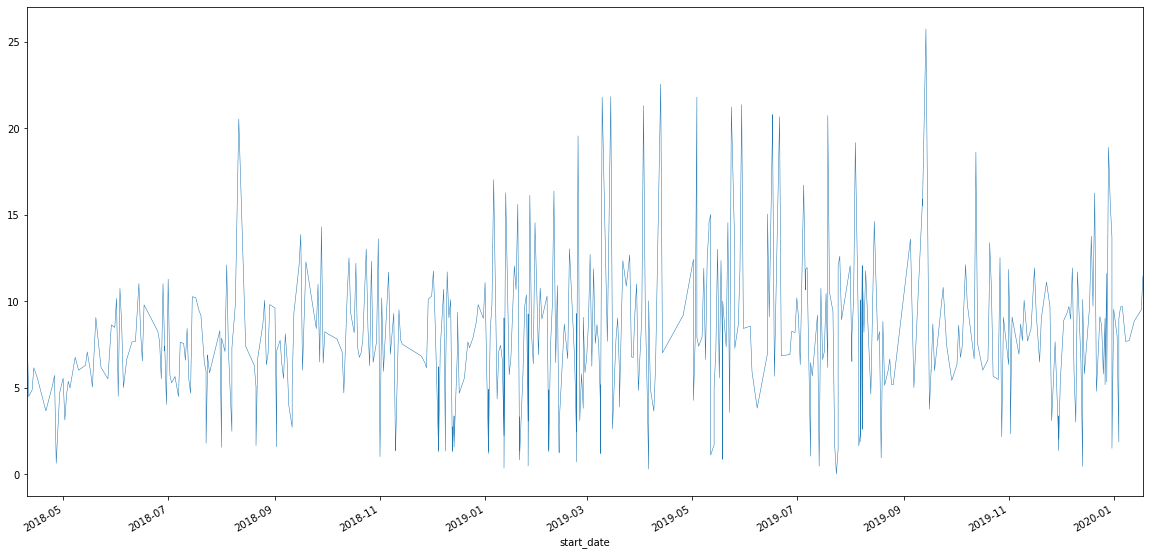

In [96]:
df["distance"].plot(linewidth=0.5)

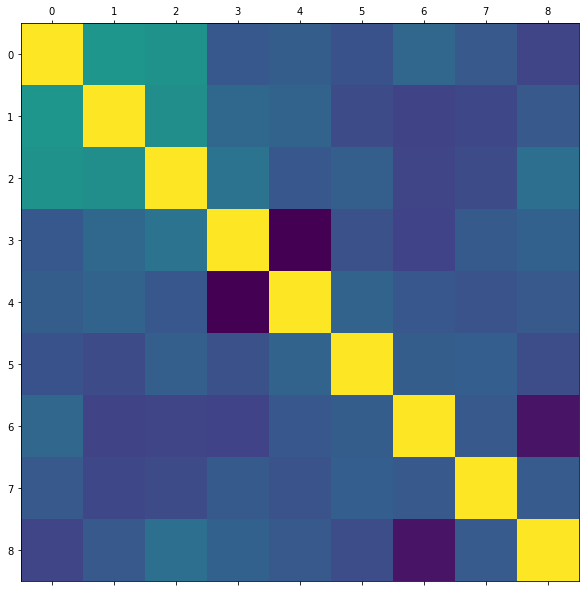

In [97]:
plt.matshow(df.corr())
plt.show()

In [98]:
df.corr()

,average_speed,max_speed,distance,year,month,day,hour,minute,day_of_week
average_speed,1.000000,0.342664,0.323484,-0.006386,0.024480,-0.035620,0.071217,0.000342,-0.097383
max_speed,0.342664,1.000000,0.296047,0.083798,0.054544,-0.069219,-0.105143,-0.084885,-0.000932
distance,0.323484,0.296047,1.000000,0.139321,-0.008077,0.033902,-0.099618,-0.064270,0.116708
year,-0.006386,0.083798,0.139321,1.000000,-0.387364,-0.045098,-0.105589,0.002864,0.045304
month,0.024480,0.054544,-0.008077,-0.387364,1.000000,0.052826,-0.008732,-0.031590,0.001770
day,-0.035620,-0.069219,0.033902,-0.045098,0.052826,1.000000,0.021918,0.028476,-0.057109
hour,0.071217,-0.105143,-0.099618,-0.105589,-0.008732,0.021918,1.000000,0.002721,-0.314722
minute,0.000342,-0.084885,-0.064270,0.002864,-0.031590,0.028476,0.002721,1.000000,0.010416
day_of_week,-0.097383,-0.000932,0.116708,0.045304,0.001770,-0.057109,-0.314722,0.010416,1.000000


In [101]:
type(df["moving_time"][0])

str